In [1]:
# What GPU I have
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug  7 21:29:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import random

random.seed(123)

random.random()

0.052363598850944326

In [3]:

random.random()

0.08718667752263232

In [4]:
import tensorflow as tf 
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import *
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import *

import keras
from keras.layers import Dropout, MaxPooling1D, Dense, Flatten, SimpleRNN, LSTM, Bidirectional

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
X_train = pd.read_csv("/content/drive/My Drive/Thesis/Data/Hours/X_train_hours.csv", sep = ';', encoding = 'latin1', header = None)
y_train = pd.read_csv("/content/drive/My Drive/Thesis/Data/Hours/y_train_hours.csv", sep = ';', encoding = 'latin1', header = None)
X_test = pd.read_csv("/content/drive/My Drive/Thesis/Data/Hours/X_test_hours.csv", sep = ';', encoding = 'latin1', header = None)
y_test = pd.read_csv("/content/drive/My Drive/Thesis/Data/Hours/y_test_hours.csv", sep = ';', encoding = 'latin1', header = None)

In [7]:
y_train = y_train[X_train.sum(axis = 1) != 0]
X_train = X_train[X_train.sum(axis = 1) != 0]
# Remove all rows which have a sum of zero accross the row

In [8]:
X_train_scaled_m_m = X_train.sub(X_train.min(axis=1), axis=0).divide(X_train.max(axis=1).sub(X_train.min(axis=1)), axis=0)

X_test_scaled_m_m = X_test.sub(X_test.min(axis=1), axis=0).divide(X_test.max(axis=1).sub(X_test.min(axis=1)), axis=0)

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [10]:
X_train_scaled_m_m.columns

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879],
           dtype='int64', length=2880)

In [11]:
img_0 = np.array(X_train_scaled_m_m.iloc[0]).reshape(-1,24) # Example of how one time series turns into image

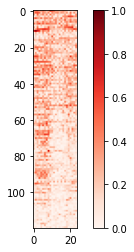

In [12]:
plt.imshow(img_0, cmap = "Reds")
plt.colorbar()

In [13]:
X_train_images = np.array(X_train_scaled_m_m).reshape(len(X_train_scaled_m_m), -1, 24)
X_test_images = np.array(X_test_scaled_m_m).reshape(len(X_test_scaled_m_m), -1, 24)

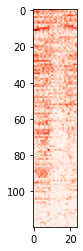

In [14]:
plt.imshow(X_train_images[0], cmap = "Reds")

In [15]:
X_train_images.shape

(174, 120, 24)

In [16]:
(y_train == 1).shape

(174, 1)

In [17]:
no_hpumps = X_train_images[(y_train == 0)[0].values,0:,0:]
yes_hpumps = X_train_images[(y_train == 1)[0].values,0:,0:]

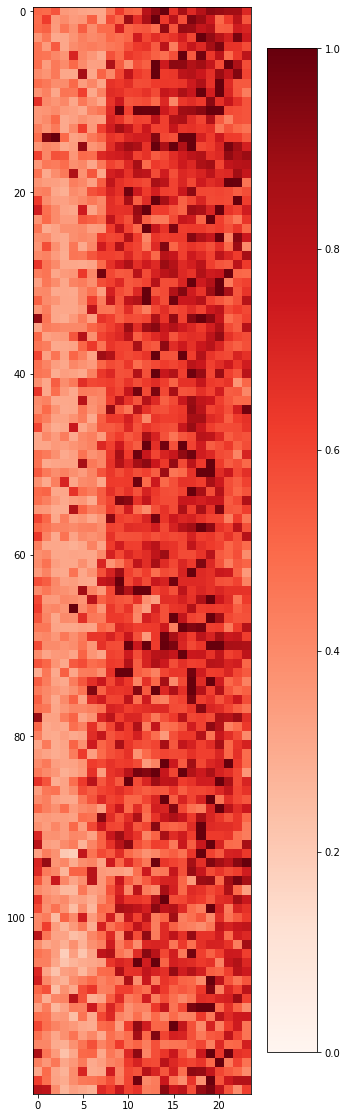

In [18]:
plt.figure(figsize = (6,20))
plt.imshow(np.max(no_hpumps,axis = 0), cmap = "Reds", vmin = 0, vmax = 1)
plt.colorbar()
# Mean of places with no heat pumps

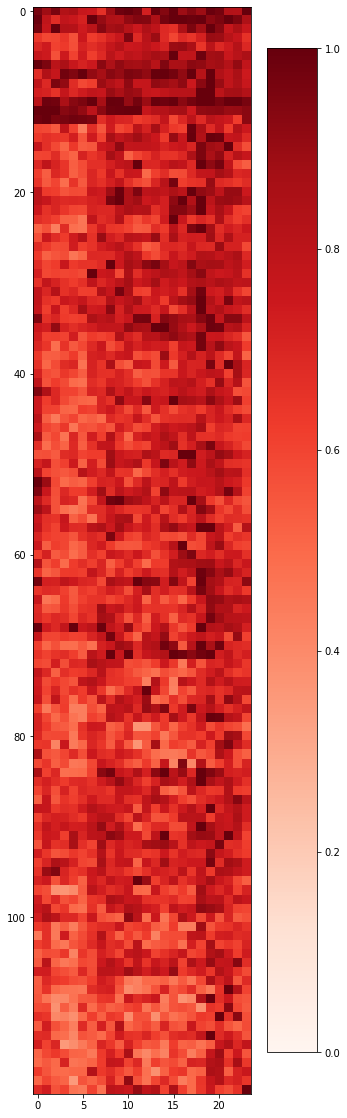

In [19]:
plt.figure(figsize = (6,20))
plt.imshow(np.max(yes_hpumps,axis = 0), cmap = "Reds", vmin = 0, vmax = 1)
# Mean of places with heat pumps
plt.colorbar()

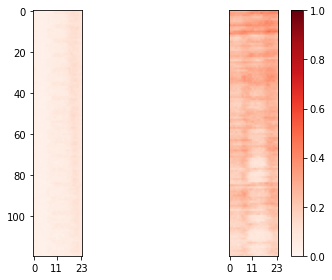

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
im1 = ax1.imshow(np.median(no_hpumps,axis = 0), cmap = "Reds", vmin = 0, vmax = 1)
im2 = ax2.imshow(np.median(yes_hpumps,axis = 0), cmap = "Reds", vmin = 0, vmax = 1)
ax2.yaxis.set_visible(False)
fig.colorbar(im2)
#labels1 = [item.get_text() for item in ax1.get_xticklabels()]
#labels2 = [item.get_text() for item in ax2.get_xticklabels()]
day = 0
#for label in labels1:
#  labels1[day] = str(day)
#  day += 1
labels = [0,11,23]

ax1.set_xticklabels(labels)
ax1.set_xticks([0,11,23])
ax1.set_xticklabels(labels)
ax2.set_xticklabels(labels)
ax2.set_xticks([0,11,23])
ax2.set_xticklabels(labels)
fig.tight_layout()
#plt.subplots_adjust(wspace=0.1, hspace=0)

In [21]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import tensorflow
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [22]:

from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

In [23]:
img_0.shape

(120, 24)

In [24]:
set_random_seed(123)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(120,24,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [25]:
set_random_seed(123)
model.compile(loss='binary_crossentropy',optimizer=SGD(momentum=0.5, decay=0.0004), metrics = ["accuracy"])


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 24, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 120, 24, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 12, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 60, 12, 32)       128       
 hNormalization)                                                 
                                                        

In [27]:
from tensorflow.keras.models import load_model

In [28]:
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 100)
mc = ModelCheckpoint('/content/drive/My Drive/Thesis/NeuralNetworks/Convolutional/Hourly/best_untuned_model.h5', monitor = "val_loss", mode = "min", save_best_only = True)

In [29]:
set_random_seed(123)
history = model.fit(X_train_images, y_train, epochs = 300, validation_split=0.1, batch_size = 32, callbacks = [es, mc])

Epoch 1/300
5/5 [==============================] - 15s 639ms/step - loss: 1.2510 - accuracy: 0.7692 - val_loss: 0.6414 - val_accuracy: 0.3889
Epoch 2/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4633 - accuracy: 0.8718 - val_loss: 0.6004 - val_accuracy: 0.7222
Epoch 3/300
5/5 [==============================] - 0s 41ms/step - loss: 0.1811 - accuracy: 0.9295 - val_loss: 0.5897 - val_accuracy: 0.8889
Epoch 4/300
5/5 [==============================] - 0s 36ms/step - loss: 0.0748 - accuracy: 0.9744 - val_loss: 0.5538 - val_accuracy: 0.8889
Epoch 5/300
5/5 [==============================] - 0s 31ms/step - loss: 0.0204 - accuracy: 1.0000 - val_loss: 0.5442 - val_accuracy: 0.8333
Epoch 6/300
5/5 [==============================] - 0s 33ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.5273 - val_accuracy: 0.8889
Epoch 7/300
5/5 [==============================] - 0s 38ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.5195 - val_accuracy: 0.8889
Epoch 8/300
5/5 [=

In [30]:
model.evaluate(X_test_images, y_test)

2/2 [==============================] - 0s 34ms/step - loss: nan - accuracy: 0.9322


[nan, 0.9322034120559692]

In [31]:
# load the saved model
#saved_model = load_model('/content/drive/My Drive/Thesis/NeuralNetworks/Convolutional/Daily/best_untuned_model.h5')
saved_model = load_model('/content/drive/My Drive/Thesis/NeuralNetworks/Convolutional/Hourly/best_untuned_model.h5')

In [32]:
saved_model.evaluate(X_test_images, y_test)

2/2 [==============================] - 0s 13ms/step - loss: nan - accuracy: 0.8983


[nan, 0.8983050584793091]

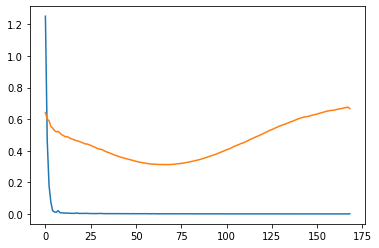

In [33]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [34]:
y_test
comparison_df = y_test.copy()
#saved_model.predict(X_test_images)
comparison_df["predict"] = saved_model.predict(X_test_images)
comparison_df
y_test

,0
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,0.0
7,1.0
8,1.0
9,0.0


In [35]:
#leakage_check = [i in X_test_images for i in X_train_images]
same_images = []
for i in np.arange(len(X_test_images)):
  for j in np.arange(len(X_train_images)):
    if np.array_equal(X_test_images[i] ,X_train_images[j]):
      same_images.append((i,j))
same_images

[]

In [36]:
np.array_equal(X_test_images[0] ,X_test_images[2])

False

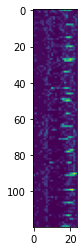

In [37]:
plt.imshow(X_test_images[3])

In [38]:
# OPTIMIZATION

In [39]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [40]:
def create_model(neurons, optimizer, learning_rate, activation, batch_norm, Conv_layers):
  opt_D = {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate), 'RMSprop': RMSprop(learning_rate=learning_rate)}
  opt = opt_D[optimizer]
  nn = Sequential()
  for i in np.arange(0, Conv_layers):
    #if i < LSTM_layers - 1:
    nn.add(Conv2D(32, (3, 3), input_shape=(120,24,1), padding='same', activation=activation))
    if batch_norm == True:
      nn.add(BatchNormalization())
    #if i == LSTM_layers - 1:
    #    nn.add(LSTM(neurons, input_shape=(120,1), return_sequences= False))
    #    nn.add(Dropout(dropout_rate))
  nn.add(Flatten()) 
  nn.add(Dense(1, activation='sigmoid'))
  nn.compile(optimizer= opt, loss='binary_crossentropy', metrics= ["accuracy"])
  return nn

In [41]:
create_model(neurons = 128, optimizer = "Adam", learning_rate = 0.001, activation = "relu", batch_norm = True, Conv_layers = 1).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 120, 24, 32)       320       
                                                                 
 batch_normalization_2 (Batc  (None, 120, 24, 32)      128       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 92160)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 92161     
                                                                 
Total params: 92,609
Trainable params: 92,545
Non-trainable params: 64
_________________________________________________________________


In [42]:
es1 = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)
mc1 = ModelCheckpoint('/content/drive/My Drive/Thesis/NeuralNetworks/Convolutional/Hourly/best_tuned_model.h5', monitor = "val_loss", mode = "min", save_best_only = True)

In [43]:
random.seed(123)
set_random_seed(123)
model = KerasClassifier(build_fn=create_model, verbose = 0, callbacks = [es1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
%%time
random.seed(123)
set_random_seed(123)
np.random.seed(123)
import logging, sys
logging.disable(sys.maxsize)
neurons_L = [8,16,32, 128]
opt_L = ["Adam", "SGD", "RMSprop"]
lr_L = [ 0.0001, 0.001]
activation_L = ['relu', 'tanh']#, 'tanh']#, "selu"]
batch_norm_L = [True, False]
Conv_layers_L = [1, 2, 4]#,5,6,7]
batch_size_L = [32, 64]#, 64]#, 128]
epochs_L = [200]
param_grid = dict(neurons=neurons_L, optimizer = opt_L, learning_rate = lr_L, activation = activation_L, batch_norm = batch_norm_L, Conv_layers = Conv_layers_L, batch_size = batch_size_L, epochs = epochs_L )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring = "accuracy", verbose = 10 )
results = grid.fit(X_train_images, y_train)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 1min 28s, sys: 7.73 s, total: 1min 36s
Wall time: 2h 8min 12s


In [ ]:
results.cv_results_

{'mean_fit_time': array([ 9.73458974,  8.03034949,  6.50994174,  7.97834841,  5.6760362 ,
         8.42063991,  7.34228841,  7.32758236,  8.08449491,  7.70167939,
         6.16777611,  8.45713154,  6.90816776,  7.80570499,  6.30316997,
         7.98189847,  7.13251384,  7.30681562,  6.14441013,  7.51021433,
         7.8369507 ,  7.24384793,  7.17010736,  9.58962695,  4.89975762,
         5.19083627,  5.12516936,  4.41176422,  4.86897691,  4.99874067,
         5.09963624,  5.22198987,  5.23159051,  5.32351327,  5.17310866,
         4.51361481,  4.70944126,  4.3871719 ,  4.98997649,  5.19135189,
         4.53284494,  5.4712019 ,  4.78778783,  4.35702125,  5.63261143,
         4.7832226 ,  4.60541177,  5.74219831,  5.67685016,  5.68033338,
         7.07450358,  6.04350273,  5.97938617,  6.37465525,  7.71169178,
         5.20977712,  7.97232652,  5.93474746,  7.66584913,  7.60338449,
         5.39153854,  5.92094644,  7.26306526,  7.19908841,  5.52455862,
         7.66501562,  6.2031397 , 

In [ ]:
results.best_params_

{'Conv_layers': 4,
 'activation': 'tanh',
 'batch_norm': False,
 'batch_size': 32,
 'epochs': 200,
 'learning_rate': 0.0001,
 'neurons': 8,
 'optimizer': 'Adam'}

In [ ]:
results.best_score_

0.9022988505747126

In [ ]:
np.array(results.cv_results_['params'])[np.argsort(-1*results.cv_results_["mean_test_score"])]#[np.argsort(results.cv_results_["mean_test_score"])]

array([{'Conv_layers': 4, 'activation': 'tanh', 'batch_norm': False, 'batch_size': 32, 'epochs': 200, 'learning_rate': 0.0001, 'neurons': 8, 'optimizer': 'Adam'},
       {'Conv_layers': 4, 'activation': 'tanh', 'batch_norm': False, 'batch_size': 64, 'epochs': 200, 'learning_rate': 0.001, 'neurons': 8, 'optimizer': 'Adam'},
       {'Conv_layers': 4, 'activation': 'relu', 'batch_norm': False, 'batch_size': 64, 'epochs': 200, 'learning_rate': 0.0001, 'neurons': 8, 'optimizer': 'RMSprop'},
       {'Conv_layers': 4, 'activation': 'tanh', 'batch_norm': False, 'batch_size': 64, 'epochs': 200, 'learning_rate': 0.001, 'neurons': 16, 'optimizer': 'Adam'},
       {'Conv_layers': 4, 'activation': 'relu', 'batch_norm': False, 'batch_size': 32, 'epochs': 200, 'learning_rate': 0.0001, 'neurons': 16, 'optimizer': 'RMSprop'},
       {'Conv_layers': 4, 'activation': 'tanh', 'batch_norm': False, 'batch_size': 64, 'epochs': 200, 'learning_rate': 0.001, 'neurons': 32, 'optimizer': 'Adam'},
       {'Conv_la

In [ ]:
-1*np.sort(-1*results.cv_results_["mean_test_score"])

array([0.90229885, 0.90229885, 0.8908046 , 0.8908046 , 0.88505747,
       0.88505747, 0.88505747, 0.88505747, 0.87931034, 0.87931034,
       0.87931034, 0.87931034, 0.87931034, 0.87931034, 0.87931034,
       0.87931034, 0.87931034, 0.87931034, 0.87931034, 0.87931034,
       0.87931034, 0.87931034, 0.87931034, 0.87931034, 0.87931034,
       0.87356322, 0.87356322, 0.87356322, 0.87356322, 0.87356322,
       0.87356322, 0.87356322, 0.87356322, 0.87356322, 0.87356322,
       0.87356322, 0.87356322, 0.87356322, 0.87356322, 0.87356322,
       0.87356322, 0.86781609, 0.86781609, 0.86781609, 0.86781609,
       0.86781609, 0.86781609, 0.86781609, 0.86781609, 0.86781609,
       0.86781609, 0.86781609, 0.86781609, 0.86781609, 0.86781609,
       0.86781609, 0.86781609, 0.86781609, 0.86781609, 0.86781609,
       0.86781609, 0.86781609, 0.86781609, 0.86781609, 0.86781609,
       0.86781609, 0.86781609, 0.86781609, 0.86781609, 0.86781609,
       0.86781609, 0.86781609, 0.86781609, 0.86781609, 0.86781

In [44]:
set_random_seed(123)
#best_tuned_model = create_model(neurons = results.best_params_["neurons"], optimizer = results.best_params_["optimizer"], activation = results.best_params_["activation"], batch_norm = results.best_params_["batch_norm"], Conv_layers = results.best_params_["Conv_layers"], learning_rate = results.best_params_["learning_rate"])
best_tuned_model = create_model(neurons = 16, optimizer = "Adam", activation = "tanh", batch_norm = False, Conv_layers = 4, learning_rate = 0.001)
#best_tuned_model = create_model(neurons = 16, optimizer = "Adam", activation = "relu", batch_norm = False, Conv_layers = 4, learning_rate = 0.0001)

In [45]:
best_tuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 120, 24, 32)       320       
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 24, 32)       9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 24, 32)       9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 120, 24, 32)       9248      
                                                                 
 flatten_2 (Flatten)         (None, 92160)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 92161     
                                                                 
Total params: 120,225
Trainable params: 120,225
Non-tr

In [46]:
epochs = 300
verbose = 1

In [47]:
%%time
set_random_seed(123)
history_best_tuned = best_tuned_model.fit(np.array(X_train_images), y_train, epochs=epochs, verbose=verbose, batch_size = 32, validation_split=0.1, callbacks = [es1,mc1])#, mc1])

Epoch 1/300
5/5 [==============================] - 2s 342ms/step - loss: 0.9537 - accuracy: 0.6218 - val_loss: 0.7454 - val_accuracy: 0.3889
Epoch 2/300
5/5 [==============================] - 0s 62ms/step - loss: 0.5097 - accuracy: 0.7308 - val_loss: 0.3528 - val_accuracy: 0.8889
Epoch 3/300
5/5 [==============================] - 0s 36ms/step - loss: 0.3523 - accuracy: 0.8782 - val_loss: 0.4082 - val_accuracy: 0.8333
Epoch 4/300
5/5 [==============================] - 0s 42ms/step - loss: 0.2645 - accuracy: 0.8910 - val_loss: 0.2995 - val_accuracy: 0.8889
Epoch 5/300
5/5 [==============================] - 0s 21ms/step - loss: 0.1743 - accuracy: 0.9359 - val_loss: 0.4702 - val_accuracy: 0.7778
Epoch 6/300
5/5 [==============================] - 0s 31ms/step - loss: 0.1422 - accuracy: 0.9744 - val_loss: 0.3674 - val_accuracy: 0.8889
Epoch 7/300
5/5 [==============================] - 0s 22ms/step - loss: 0.0915 - accuracy: 0.9872 - val_loss: 0.3244 - val_accuracy: 0.8889
Epoch 8/300
5/5 [==

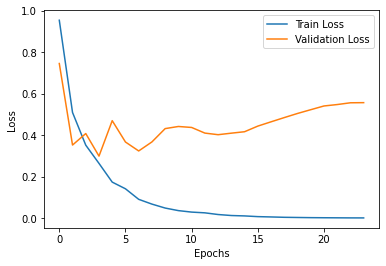

In [48]:
plt.figure()
plt.plot(history_best_tuned.history["loss"], label = "Train Loss")
plt.plot(history_best_tuned.history["val_loss"], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

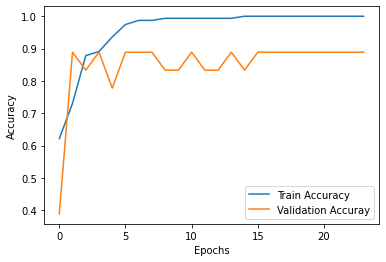

In [49]:
plt.figure()
plt.plot(history_best_tuned.history["accuracy"], label = "Train Accuracy")
plt.plot(history_best_tuned.history["val_accuracy"], label = "Validation Accuray")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [61]:
best_tuned_model.evaluate(X_test_images, y_test)

2/2 [==============================] - 0s 25ms/step - loss: nan - accuracy: 0.9492


[nan, 0.9491525292396545]

In [51]:
best_tuned_saved_model = load_model('/content/drive/My Drive/Thesis/NeuralNetworks/Convolutional/Hourly/best_tuned_model.h5')

In [52]:
best_tuned_saved_model.evaluate(X_test_images, y_test, )

2/2 [==============================] - 0s 16ms/step - loss: nan - accuracy: 0.9492


[nan, 0.9491525292396545]

In [53]:
# PRECISION RECALL CURVE

In [54]:

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


P-R AUC 0.9829289114982455
P-R AUC 0.9833333333333333


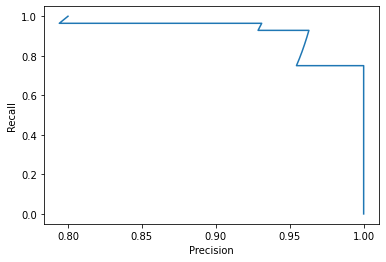

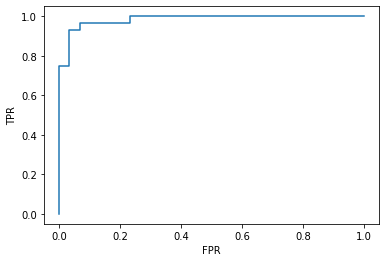

In [59]:
probs = best_tuned_saved_model.predict(X_test_images).ravel()
y_test_pr = y_test[np.isnan(probs)==False]
probs = probs[np.isnan(probs)==False]
precisions, recalls, threshholds = precision_recall_curve(y_test_pr, probs)
plt.figure()
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")
print("P-R AUC", auc( recalls, precisions))
fpr, tpr, thresholds = roc_curve(y_test_pr, probs, pos_label=1)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
print("P-R AUC", auc( fpr, tpr))

In [ ]:
#ROC

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_pr, probs, pos_label=1)

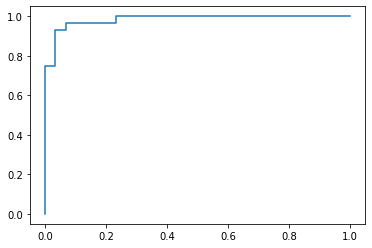

In [ ]:
plt.plot(fpr, tpr)

In [ ]:
auc(fpr, tpr)

0.9833333333333333

In [ ]:
roc_auc_score(y_test_pr, probs)

0.9833333333333333

In [ ]:
# VISUALIZATION

In [ ]:
!pip install shap
import shap
from tensorflow.keras.models import Sequential
# from keras import layers
# from keras import regularizers
# from keras import backend as K
# from keras.callbacks import ModelCheckpoint
# from keras import *
# from tensorflow.keras.callbacks import EarlyStopping

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import math
# from sklearn.model_selection import *

# import keras
from tensorflow.keras.layers import Dropout, MaxPooling1D, Dense, Flatten, SimpleRNN, LSTM, Bidirectional

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.8 MB/s 


In [ ]:
set_random_seed(123)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(120,24,1), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
set_random_seed(123)
model.compile(loss='binary_crossentropy',optimizer=SGD(momentum=0.5, decay=0.0004), metrics = ["accuracy"])

In [ ]:
history = model.fit(X_train_images, y_train, epochs = 300, validation_split=0.1, batch_size = 32, callbacks = [es])

Epoch 1/300
5/5 [==============================] - 1s 52ms/step - loss: 0.6725 - accuracy: 0.5064 - val_loss: 0.6924 - val_accuracy: 0.3333
Epoch 2/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6538 - accuracy: 0.5128 - val_loss: 0.6856 - val_accuracy: 0.3333
Epoch 3/300
5/5 [==============================] - 0s 27ms/step - loss: 0.6401 - accuracy: 0.5256 - val_loss: 0.6756 - val_accuracy: 0.3333
Epoch 4/300
5/5 [==============================] - 0s 15ms/step - loss: 0.6260 - accuracy: 0.5385 - val_loss: 0.6636 - val_accuracy: 0.3889
Epoch 5/300
5/5 [==============================] - 0s 17ms/step - loss: 0.6111 - accuracy: 0.5449 - val_loss: 0.6524 - val_accuracy: 0.3889
Epoch 6/300
5/5 [==============================] - 0s 16ms/step - loss: 0.5958 - accuracy: 0.5962 - val_loss: 0.6329 - val_accuracy: 0.5556
Epoch 7/300
5/5 [==============================] - 0s 12ms/step - loss: 0.5806 - accuracy: 0.7115 - val_loss: 0.6114 - val_accuracy: 0.6111
Epoch 8/300
5/5 [===

In [ ]:
background = X_train_images[:59]
background.shape
#background[0].shape

(59, 120, 24)

In [ ]:
#  class label list
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#                'dog', 'frog', 'horse', 'ship', 'truck']
# example image for each class
images_dict = dict()
for i, l in enumerate(y_train[0]):
  if len(images_dict)==2:
    break
  if l not in images_dict.keys():
    images_dict[l] = X_train_images[i]
images_dict = dict(sorted(images_dict.items()))
    
# # example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test[0]):
   if len(x_test_dict)==2:
     break
   if l not in x_test_dict.keys():
     x_test_dict[l] = X_test_images[i]
# # order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)
# # Compute predictions
predictions = model.predict(x_test_each_class)
predictions
predicted_class = np.round(predictions)
predicted_class
x_test_each_class.reshape(2,120,24,1)

array([[[[0.01418842],
         [0.01135074],
         [0.0045403 ],
         ...,
         [0.01475596],
         [0.01475596],
         [0.00340522]],

        [[0.0045403 ],
         [0.01418842],
         [0.01305335],
         ...,
         [0.01305335],
         [0.02043133],
         [0.01986379]],

        [[0.02213394],
         [0.01021566],
         [0.00908059],
         ...,
         [0.0584563 ],
         [0.03291714],
         [0.00794552]],

        ...,

        [[0.02099886],
         [0.01702611],
         [0.00681044],
         ...,
         [0.02724177],
         [0.02383655],
         [0.00964813]],

        [[0.03007946],
         [0.00908059],
         [0.01305335],
         ...,
         [0.00510783],
         [0.02099886],
         [0.01759364]],

        [[0.00397276],
         [0.01418842],
         [0.01816118],
         ...,
         [0.00964813],
         [0.01986379],
         [0.0153235 ]]],


       [[[0.59636814],
         [0.70099051],
         [0.59

array([[[[0.01418842],
         [0.01135074],
         [0.0045403 ],
         ...,
         [0.01475596],
         [0.01475596],
         [0.00340522]],

        [[0.0045403 ],
         [0.01418842],
         [0.01305335],
         ...,
         [0.01305335],
         [0.02043133],
         [0.01986379]],

        [[0.02213394],
         [0.01021566],
         [0.00908059],
         ...,
         [0.0584563 ],
         [0.03291714],
         [0.00794552]],

        ...,

        [[0.02099886],
         [0.01702611],
         [0.00681044],
         ...,
         [0.02724177],
         [0.02383655],
         [0.00964813]],

        [[0.03007946],
         [0.00908059],
         [0.01305335],
         ...,
         [0.00510783],
         [0.02099886],
         [0.01759364]],

        [[0.00397276],
         [0.01418842],
         [0.01816118],
         ...,
         [0.00964813],
         [0.01986379],
         [0.0153235 ]]],


       [[[0.59636814],
         [0.70099051],
         [0.59

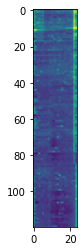

In [ ]:
plt.imshow(background[3])
background.shape
X_test_images.shape
X_test_images.reshape(59,120,24,1)

In [ ]:
background.shape
X_test_images.shape

(59, 120, 24)

In [ ]:

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(x_test_each_class)
#shap_values
e


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


ValueError: ignored

In [ ]:
for i, j in enumerate(y_train[0]):
  print((i,j))


In [ ]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()
  
  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()